In [1]:
# We plot the top-k features selected by the sparse autoencoder for each category.
# We make N axes to illustrate the top-k features for N categories.

In [ ]:
import os
import sys
sys.path.append(os.path.abspath("../"))  # 절대 경로로 추가
from infos import categories  # 이제 infos의 categories를 가져올 수 있음
print(categories)

from keat_small.load_data import load_keat_small
path ="/data1/bumjin/nlp_data/datahub/MRL-2021/dataset/keat"
datadict, json_data = load_keat_small(path)
cluster_wise_text_indices = {c:[] for c in categories}
for i, sample in enumerate(datadict['train']):
    for c in sample['categories']:
        cluster_wise_text_indices[c].append(i)

activations_path = "../outputs"
lang = "ko"
name = f"exaone_8b_train_{lang}"
q = 2 
sae= 'gated'
path = f"{activations_path}/sae/{sae}/{name}_q{q}"

import torch 
import pickle
from tqdm import tqdm
from nlp_features.sae.standard_sae import AutoEncoder
from nlp_features.sae.gated_sae import GatedAutoEncoder

activations = pickle.load(open(f'{activations_path}/activations_{name}.pkl', 'rb'))
act = activations[f'{lang}_residual_q{q}']   

if sae == 'standard':
    ae = AutoEncoder.from_pretrained(f"{path}/model.pth")
elif sae == 'gated':
    ae = GatedAutoEncoder.from_pretrained(f"{path}/model.pth")


['노동_복지', '학술_문화재', '사회일반', '서비스_쇼핑', '중남미', '출판', '중국', '생활', '일본', '러시아', '금융_재테크', '국제', '사건_사고', '산업_기업', '종교', '장애인', '전시_공연', '유통', '골프', '월드컵', '정치', '올림픽_아시안게임', '외교', '콘텐츠', '미술_건축', '과학', '여성', '메이저리그', '사회', '자동차', '보안', '문화', '부동산', '경제', '국제경제', '야구', '행정_자치', '중동_아프리카', '모바일', '영화', '스포츠', '무역', '농구_배구', 'IT_과학일반', '인터넷_SNS', '문화일반', '청와대', '취업_창업', '해외축구', '아시아', '요리_여행', '정치일반', '교육_시험', '방송_연예', '증권_증시', '유럽_EU', '환경', 'IT_과학', '축구', '스포츠일반', '북한', '자원', '의료_건강', '한국프로야구', '국회_정당', '경제일반', '음악', '반도체', '미국_북미', '한국프로축구', '국제일반']


In [3]:
def get_feature_counts(sae, num_dictionary, activations):
    n_samples = len(activations)
    feature_counts = torch.zeros(n_samples, num_dictionary)
    for s in tqdm(range(n_samples)):
        sample = activations[s].to('cuda')
        reconstructed_activations, features = sae(sample, output_features=True)
        feature_counts[s] = torch.sum(features, dim=0).detach().cpu()
    return feature_counts

ae.to('cuda')
num_dictionary = ae.dict_size 
feature_counts = get_feature_counts(ae, num_dictionary, act)


100%|██████████| 5034/5034 [01:46<00:00, 47.24it/s]


In [4]:

# N x F 행렬에서 IDF 계산
n_samples = feature_counts.shape[0]
doc_freq = (feature_counts > 0).float().sum(dim=0)  # 각 feature가 등장한 문서 수
idf = torch.log(n_samples / (doc_freq + 1))  # smooth IDF

# TF-IDF 계산
tf_idf = feature_counts * idf.unsqueeze(0)

# L2 정규화
normalized_features = tf_idf / torch.norm(tf_idf, dim=1, keepdim=True)
category_features = {cat: normalized_features[indices].mean(dim=0) for cat, indices in cluster_wise_text_indices.items()}
# category_features = {cat: feature_counts[indices].mean(dim=0) for cat, indices in cluster_wise_text_indices.items()}

In [5]:
# 카테고리별 특징적인 feature top-k 추출
top_k = 50
all_top_features = []
category_features_count = {}
for cat, feat in category_features.items():
    top_features = torch.topk(feat, k=top_k, dim=-1)
    category_features_count[cat] = top_features.indices.tolist()
    # print(f"Category {cat} top features:", top_features.indices.tolist())
    all_top_features.extend(category_features_count[cat])
all_top_features = list(set(all_top_features))
print(len(all_top_features))

901


In [6]:
from umap import UMAP
feature_vectors = ae.decoder.weight.detach().cpu()
print(feature_vectors.shape)
selected_feature_vectors = feature_vectors[:, all_top_features]
print(selected_feature_vectors.shape)
umap = UMAP(n_components=2, random_state=42)
feature_vectors_2d = umap.fit_transform(selected_feature_vectors.T.numpy())  # (100000, 4096) -> (100000, 2))
print(feature_vectors_2d.shape)

2024-11-26 17:22:53.209973: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 17:22:53.222090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 17:22:53.235124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 17:22:53.238868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 17:22:53.249892: I tensorflow/core/platform/cpu_feature_guar

torch.Size([4096, 100000])
torch.Size([4096, 901])


/home/bumjin/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(901, 2)


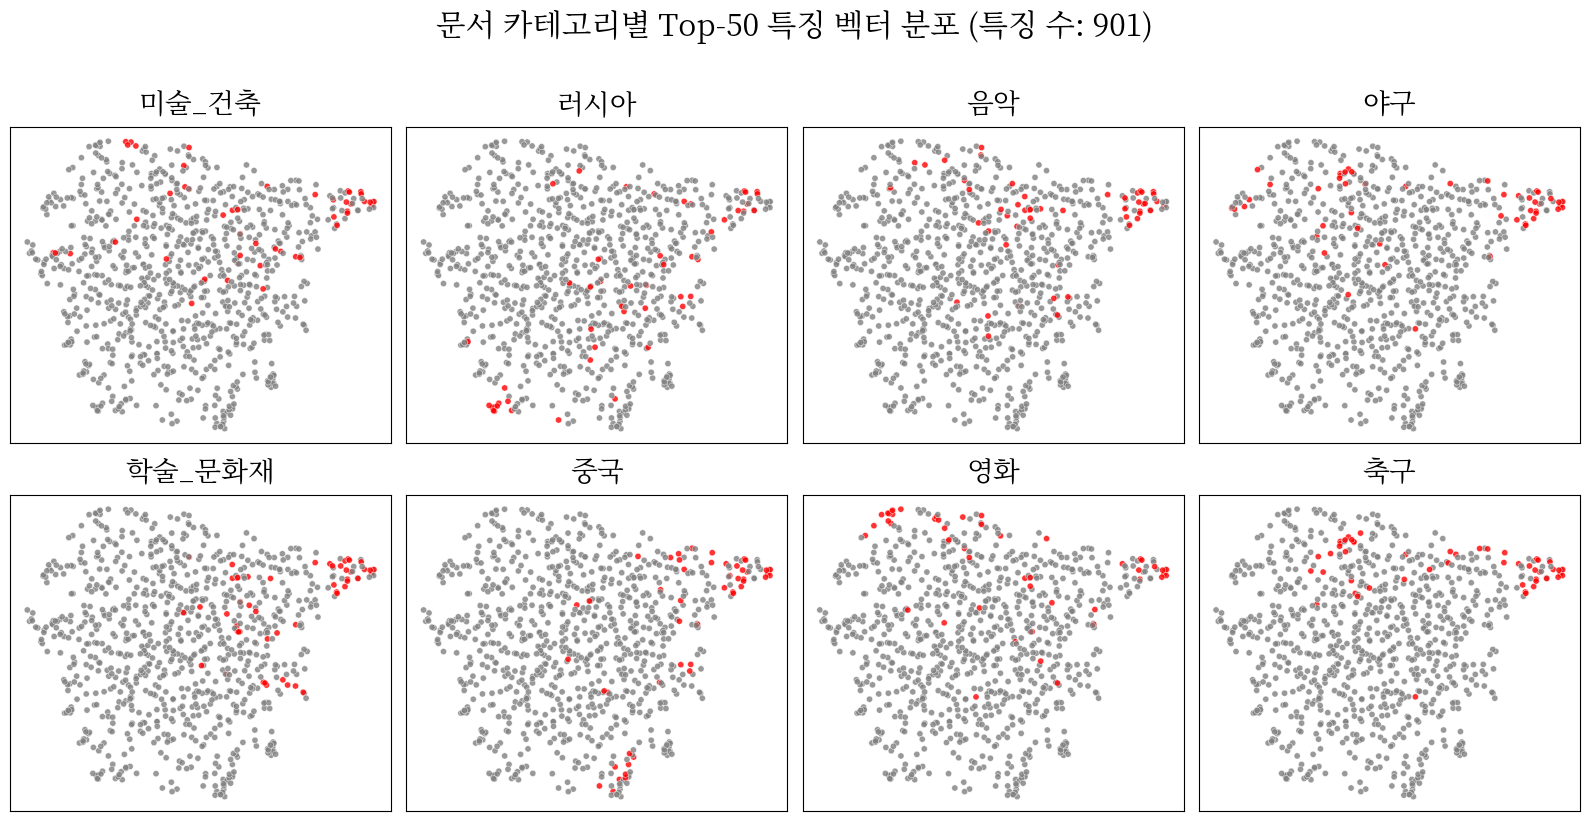

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
# 폰트 설정
plt.rcParams['font.family'] = 'Noto Serif CJK JP'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

n_columns = 4
n_rows = 2
fig, axes = plt.subplots(n_rows, n_columns, figsize=(16, 8))

# 전체 제목 추가
fig.suptitle(f'문서 카테고리별 Top-{top_k} 특징 벡터 분포 (특징 수: {len(all_top_features)})', fontsize=22, y=1.02)

selected_categories = ['미술_건축', '러시아', '음악', '야구',
                      '학술_문화재', '중국', '영화', '축구']

for a, ax in enumerate(axes.flatten()):
    if a < len(selected_categories):
        cluster_index = categories.index(selected_categories[a])
        clutser_colors = []
        for i in range(len(all_top_features)):  
            if all_top_features[i] in category_features_count[selected_categories[a]]:
                clutser_colors.append('red')
            else:
                clutser_colors.append('gray')  # 회색을 더 연하게
        
        # 제목 스타일 개선
        ax.set_title(selected_categories[a], pad=10, fontsize=20)
        
        # 산점도 스타일 개선
        sns.scatterplot(x=feature_vectors_2d[:, 0], 
                       y=feature_vectors_2d[:, 1], 
                       hue=clutser_colors, 
                       alpha=0.8,  # 투명도 약간 증가
                       ax=ax, 
                       legend=False,
                       palette=['red', 'gray'],
                       hue_order=['red', 'gray'],
                       s=20)  # 점 크기 약간 증가
        
        # 테두리 추가
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
    
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig(f'assets/{name}_{sae}_q{q}_topk{top_k}_umap.png', dpi=300, bbox_inches='tight')

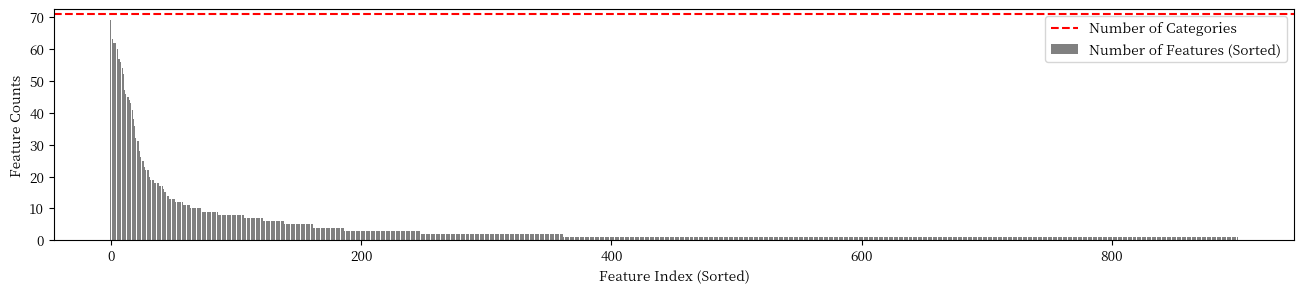

In [8]:
# hist plot of the feature activated for category
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("normal")

counts = np.zeros(len(all_top_features))
mapping = {c:i for i, c in enumerate(all_top_features)}
for cat, indices in category_features_count.items():
    for i in indices:
        if i in mapping:
            counts[mapping[i]] += 1
sorted_counts = sorted(counts, reverse=True)

plt.figure(figsize=(16, 3))

plt.bar(list(range(len(sorted_counts))), sorted_counts, color='gray')
plt.axhline(y=len(category_features_count), color='red', linestyle='--')
plt.legend(['Number of Categories', 'Number of Features (Sorted)'])
plt.xlabel("Feature Index (Sorted)")
plt.ylabel("Feature Counts")
plt.savefig(f'assets/{name}_{sae}_q{q}_topk{top_k}_feature_counts.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
sorted_counts[:10]

[69.0, 63.0, 62.0, 62.0, 62.0, 60.0, 57.0, 57.0, 56.0, 54.0]